## Sandox for Developing Resnet
Notes, ideas, and general approach to building Resnet from the ground up.

## General Approach

fastai for data handling and training, pytorch for architecure. 

1. Use fast.ai for downloading data / preprocessing / loading / augmentations etc.
- Unroll and practice NN building and training loops
- Create a basic neural network to run through MNIST using pytorch
- Create a better neural network with multiple layers and convolutions in pytorch
- Download CIFAR
- Create VGG
- Create ResNet
- Create wide ResNet
- figure out how to use performance improvements from fastai pillo
- Download COCO
- Try training only on COCO
- Try training on CIFAR, then COCO
- Try making final Detectron Wide Resnet using  
- pretrain on imagenet, then COCO 
- Clean up and put into module for use as backbone retinanet
- Do a short write up of experience

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.datasets import *
from dataclasses import dataclass

## MNIST

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

[PosixPath('/home/sudosharma/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/home/sudosharma/.fastai/data/mnist_sample/models'),
 PosixPath('/home/sudosharma/.fastai/data/mnist_sample/train'),
 PosixPath('/home/sudosharma/.fastai/data/mnist_sample/valid')]

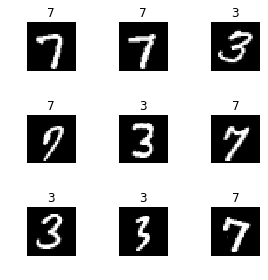

In [5]:
data = ImageDataBunch.from_folder(path)
data.show_batch(rows=3, figsize=(4, 4))

## NN v1

In [6]:
model = simple_cnn((3, 16, 16, 2))
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.118993,0.093312,0.966143,00:01


## NN v2

In [7]:
model = models.resnet50
learn = create_cnn(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.128452,0.077240,0.972031,00:06


## NN v3

In [8]:
@dataclass
class PrintOutput(LearnerCallback):
    """Function to figure out if fastai is modifying final tensor before loss_func."""
    learn: Learner

    def on_loss_begin(self, **kwargs):
        if kwargs['num_batch'] == 1: print(kwargs['last_output'].shape)
        return kwargs['last_output']

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [9]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(3*28*28, 50), nn.ReLU(True),
    nn.Linear(50, 50)
)
learn = Learner(data, model, metrics=accuracy)
cb = PrintOutput(learn)
learn.fit(1, callbacks=[cb])

epoch,train_loss,valid_loss,accuracy,time
1,0.045300,0.059831,0.984298,00:00


torch.Size([64, 50])


## NN v4

In [10]:
model = nn.Sequential(
    nn.Conv2d(3, 256, 3, 1), nn.ReLU(True),
    nn.Conv2d(256, 128, 3, 1), nn.ReLU(True),
    nn.Conv2d(128, 64, 3, 1), nn.ReLU(True),
    nn.AdaptiveMaxPool2d(1),
    Flatten()
)
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.116971,0.088994,0.964181,00:02


## NN v5

In [11]:
def conv(ic, oc, k=3, s=1, actn=False):
    """A conv layer module."""
    layers = [nn.Conv2d(ic, oc, k, padding=k//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

class SimpleCNN(nn.Module):
    """A convnet block using module list approach."""
    def __init__(self, *cs):
        super().__init__()
        self.layers = nn.ModuleList(
            [conv(cs[i], cs[i+1], actn=True) for i in range(len(cs)-1)])
        self.layers.extend([nn.AdaptiveMaxPool2d(1), Flatten()])
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [12]:
model = SimpleCNN(3, 256, 128, 64)
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.093087,0.056480,0.981845,00:02



## CIFAR-10

In [13]:
path = untar_data(URLs.CIFAR)
path.ls()

[PosixPath('/home/sudosharma/.fastai/data/cifar10/models'),
 PosixPath('/home/sudosharma/.fastai/data/cifar10/test'),
 PosixPath('/home/sudosharma/.fastai/data/cifar10/labels.txt'),
 PosixPath('/home/sudosharma/.fastai/data/cifar10/train')]

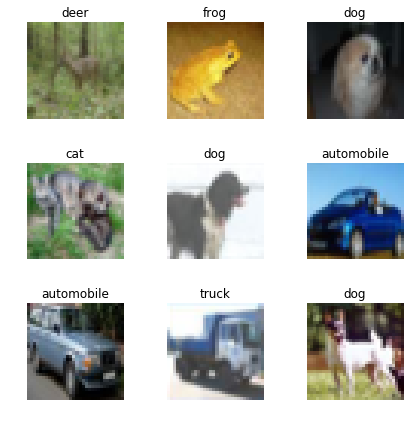

In [14]:
data = (ImageList.from_folder(path)
        .split_by_folder(valid='test')
        .label_from_folder()
        .databunch(bs = 64))
data.show_batch(3, figsize=(6, 6))

## NN v6

In [180]:
class ConvBlock(nn.Module):
    def __init__(self, ic, oc, l, actn=True, pool=None):
        super().__init__()
        self.layers = nn.ModuleList([conv(ic, oc, actn=actn)])
        self.layers.extend(conv(oc, oc, actn=actn) for _ in range(l-1))
        if pool == 'max':
            self.layers.append(nn.MaxPool2d(2, stride=2))
        elif pool == 'avg':
            self.layers.append(nn.AvgPool2d(2, stride=2))
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x
                           
class VGG_19(nn.Module):
    def __init__(self, actn=True, pool='max'):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(3, 64, 2, actn=actn, pool=pool),
            #ConvBlock(64, 128, 2, actn=actn, pool=pool),
            #ConvBlock(128, 256, 4, actn=actn, pool=pool),
            #ConvBlock(256, 512, 4, actn=actn, pool=pool),
            #ConvBlock(512, 512, 4, actn=actn, pool=pool),
            Flatten(),
            nn.Linear(16384, 10),
            #nn.Linear(4096, 4096),
            #nn.Linear(4096, 10)
        )
    
    def forward(self, x):
        return self.layers(x)

In [181]:
model = VGG_19()
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,1.556923,1.527560,0.450800,00:03
